# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

from scipy.stats import yulesimon

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=0)
RANDOM_STATE = 1

# Generate data

In [2]:
def generate_data():
    MIN_ALPHA = 2.01
    MAX_ALPHA = 3.00

    # number of alphas generated between MIN_ALPHA and MAX_ALPHA inclusive
    num_alphas = 100

    # number of samples (raws) for each alpha
    num_rows = 100

    # number of RV samples per row
    random_variate_size = 1000

    # fix loc at zero
    loc = 0

    X = np.empty((num_alphas * num_rows, 1 + random_variate_size), float)

    row = 0
    for alpha in np.linspace(MIN_ALPHA, MAX_ALPHA, num=num_alphas):
        
        alpha = round(alpha, 2)
        
        # generate samples (rows) for current alpha
        for i in range(num_rows):
            X[row, 0] = alpha
            X[row, 1:] = yulesimon.rvs(alpha, loc=loc, size=random_variate_size, random_state=RANDOM_STATE)
            row += 1

    # suffle rows
    np.random.shuffle(X)

    # separate X from y
    y = X[:, 0]
    X = X[:, 1:].astype(int)

    return X, y

X, y = generate_data()
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: (10000, 1000)
y.shape: (10000,)


# Preprocess data

In [3]:
# convert rows of X to a histogram H
nbins = np.max(X)
H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

# log scale H rows
logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)

# log number of bins
log_bins = np.log10(np.arange(nbins))

## Plot logH

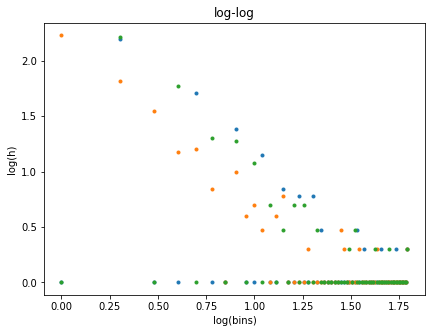

In [4]:
# plot
plt.figure(figsize=(15, 5))
ax2 = plt.subplot(1, 2, 2)
plt.gca().set(title='log-log', xlabel='log(bins)', ylabel='log(h)')
plt.scatter(log_bins, logH[0], marker='.')
plt.scatter(log_bins, logH[1], marker='.')
plt.scatter(log_bins, logH[3], marker='.')

print()

# Split train/validation/test

In [5]:
# train/test
X_train, X_test, y_train, y_test = train_test_split(logH, y, test_size=0.2, random_state=RANDOM_STATE)

# train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

print('X_train.shape: {}'.format(X_train.shape))
print('X_val.shape: {}'.format(X_val.shape))
print('X_test.shape: {}'.format(X_test.shape))


X_train.shape: (6000, 63)
X_val.shape: (2000, 63)
X_test.shape: (2000, 63)


## Create Model

In [6]:
def create_model(n_features, 
                 layers, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    
    # ============
    # input-layer
    # ============
    model.add(Dense(units=layers[0]
                      , input_dim=n_features
                      , kernel_initializer=init
                      , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                      , activity_regularizer=l2(a_reg_lr) if a_reg else None
                      , use_bias= (not batch_normalization)
                    ))
    
    
    if batch_normalization:
        model.add(BatchNormalization())
    
    model.add(Activation(activation))

    if dropout > 0:
        model.add(Dropout(dropout))

    # ==============
    # hidden-layers
    # ==============
    for units in layers[1:]:
        model.add(Dense(units=units
                        , kernel_initializer=init
                        , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                        , activity_regularizer=l2(a_reg_lr) if a_reg else None
                        , use_bias= (not batch_normalization)
                        ))

    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation(activation))
    
    if dropout > 0:
        model.add(Dropout(dropout))

    # =============
    # output-layer
    # =============
    model.add(Dense(units=1
                    , kernel_initializer=init
                    , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                    , activity_regularizer=l2(a_reg_lr) if a_reg else None
                    , use_bias= (not batch_normalization)
                    ))
    
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation('linear'))
    
    # if dropout > 0:
    #     model.add(Dropout(dropout))

    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

    return model

## Training

In [7]:
BATCH_SIZE = 32
# BATCH_SIZE = 8
# BATCH_SIZE = 4
MODEL_PREFIX = 'yulesimon'

def train(X_train, y_train):
    model = create_model(X_train.shape[1], 
                         layers=[1024, 1024], 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=True, 
                         dropout=0.0, 
                         optimizer=Adam(lr=1e-2), 
                         #optimizer=SGD(lr=1e-3, momentum=0.9, decay=0.01), 
                         k_reg=True, 
                         k_reg_lr=1e-5, 
                         a_reg=True, 
                         a_reg_lr=1e-5)
    
    # early-stopping
    es_patience = 50
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=1)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/{}_{}'.format(MODEL_PREFIX, date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=3000, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        callbacks=[es, reduce_lr, cp], 
                        verbose=1)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    print('model path:', model_path)
    model = keras.models.load_model(model_path)
    return model, history.history

# ------------------------------------------------------
# RUN: either train from scratch OR load existing model
# ------------------------------------------------------

LOAD_BEST = False
if LOAD_BEST:
    model_path = 'models/yulesimon_06-09-2020_23-21-37.h5'
    history_path = 'models/yulesimon_06-09-2020_23-21-37.history'
else:
    model_path = None
    history_path = None

model, history = None, None

if None == model_path:
    model, history = train(X_train, y_train)
else: # load existing model
    model = keras.models.load_model(model_path)
    if history_path:
        with open(history_path, 'rb') as f:
            history = pickle.load(f)

e: 0.0029
Epoch 26/3000
185/188 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 0.0038
Epoch 00026: val_loss did not improve from 0.00046
188/188 [==============================] - 2s 11ms/step - loss: 0.0039 - mse: 0.0038 - val_loss: 0.0038 - val_mse: 0.0037
Epoch 27/3000
184/188 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 0.0038
Epoch 00027: val_loss did not improve from 0.00046
188/188 [==============================] - 2s 11ms/step - loss: 0.0039 - mse: 0.0038 - val_loss: 0.0022 - val_mse: 0.0021
Epoch 28/3000
185/188 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 0.0038
Epoch 00028: val_loss did not improve from 0.00046
188/188 [==============================] - 2s 12ms/step - loss: 0.0039 - mse: 0.0038 - val_loss: 0.0016 - val_mse: 0.0015
Epoch 29/3000
183/188 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 0.0038
Epoch 00029: val_loss did not improve from 0.00046
188/188 [==============================] - 2

## Plot learning curves

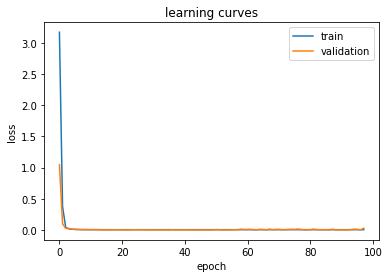

In [8]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

if True and history:
    plot_learning_curves(history)

## Predict & test accuracy

In [9]:
y_pred = model.predict(X_test).flatten()
abs_residuals = np.abs(y_test - y_pred)

print()
num_samples = abs_residuals.shape[0]
for max_abs_error in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    acc = np.sum((abs_residuals <= max_abs_error).astype(int), axis=0) / num_samples
    print('acc (max_abs_error = {}):'.format(max_abs_error), acc)

print()
print('average abs_residuals:\t', np.average(abs_residuals))

squared_error = np.square(y_test - y_pred)
mse = (squared_error).mean(axis=0)
print('mean squared error:\t', mse)

df_errors = pd.DataFrame({
    'y_test': y_test, 
    'y_pred': y_pred, 
    'abs_residuals': abs_residuals, 
    'squared_error': squared_error
})

df_errors = df_errors[['y_test', 'y_pred', 'abs_residuals', 'squared_error']]
df_errors_sorted = df_errors.sort_values(by='squared_error', ascending=False)
df_errors_sorted.head()


acc (max_abs_error = 0.01): 0.5885
acc (max_abs_error = 0.02): 0.913
acc (max_abs_error = 0.03): 0.982
acc (max_abs_error = 0.04): 1.0
acc (max_abs_error = 0.05): 1.0
acc (max_abs_error = 0.06): 1.0
acc (max_abs_error = 0.07): 1.0
acc (max_abs_error = 0.08): 1.0
acc (max_abs_error = 0.09): 1.0
acc (max_abs_error = 0.1): 1.0

average abs_residuals:	 0.010099100375175482
mean squared error:	 0.00014963446669362434


,y_test,y_pred,abs_residuals,squared_error
1758,2.91,2.876612,0.033388,0.001115
353,2.91,2.876612,0.033388,0.001115
790,2.91,2.876612,0.033388,0.001115
97,2.91,2.876612,0.033388,0.001115
1832,2.91,2.876612,0.033388,0.001115


# Plot y_test vs y_pred

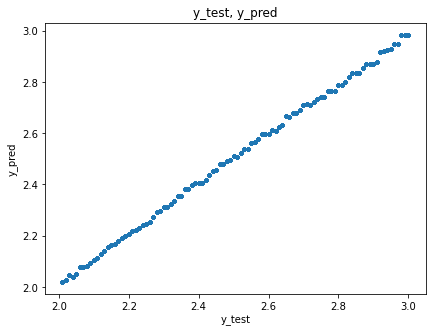

In [10]:
plt.figure(figsize=(15, 5))
ax2 = plt.subplot(1, 2, 2)
plt.gca().set(title='y_test, y_pred', xlabel='y_test', ylabel='y_pred')
plt.scatter(y_test, y_pred, marker='.')
print()